# BayesFrag - Tutorial 1: Introductory example and theoretical background

<a target="_blank" href="https://colab.research.google.com/github/bodlukas/BayesFrag/blob/main/Tutorial1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

BayesFrag is a tool to perform Bayesian parameter estimation for empirical seismic fragility models. The tool accounts for uncertainty in the ground motion intensity measures (IMs) which caused the observed damage. The methodology is presented in

>Bodenmann, L., Baker, J., and Stojadinović, B. (2023): Accounting for ground motion uncertainty in empirical seismic fragility modeling, LINK [preprint], doi: LINK.

The explanations are based on the one-dimensional case study illustrated in Figures 2 and 3 of the above manuscript.

This notebook and further supporting codes are published on [GitHub](https://github.com/bodlukas/BayesFrag) and Zenodo (doi: LINK)

## Import packages

If the notebook runs on google colab, we install [NumPyro](https://github.com/pyro-ppl/numpyro) and clone the [BayesFrag repository](https://github.com/bodlukas/BayesFrag) with the BayesFrag codebase and the tutorial data.

In [1]:
%%capture
import os
if os.getenv("COLAB_RELEASE_TAG"):
  !pip install numpyro
  !git clone https://github.com/bodlukas/BayesFrag.git
  %cd BayesFrag

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import xarray as xr

import jax
import jax.numpy as jnp
import numpyro

jax.config.update('jax_platform_name', 'cpu')
numpyro.enable_x64()

## Specify settings for inference

- IM: IM used to estimate fragility functions. For PGA use 'PGA', for SA(T=0.3s) use 'SAT0_300'.
- GMM: Ground motion model that was used to obtain mean, between-event and within-event residuals of logIM at the sites. See the third tutorial for an explanation of these computations.
- SCM: Spatial correlation model that will be used to condition the IM distribution on station data. For now `modules.spatialcorrelation` contains implementations of `EspositoIervolino2012` [(link to paper)](https://doi.org/10.1785/0120110117) and `BodenmannEtAl2023` [(link to paper)](https://doi.org/10.5194/nhess-23-2387-2023), but users can easily add additional models by following the documentation.
- list_ds: $\mathcal{DS}$, ordered list with possible damage states (including damage state 0!), $ds\in\mathcal{DS}$. Here three damage states $\mathcal{DS}=\{0,1,2\}$.
- list_bc: $\mathcal{BC}$, list with considered building classes for which to estimate fragility functions, $bc\in\mathcal{BC}$. Here all buildings are assumed to be of the same class $\mathcal{BC}=\{\text{A}\}$.

The MCMC-specific settings are directly explained below.

In [3]:
data_dir = os.path.join('data', 'tutorial1', '')

args = {
    'IM': 'PGA',
    'GMM': 'AkkarEtAl2014',
    'SCM': 'EspositoIervolino2012',
    'list_ds': [0, 1, 2],
    'list_bc': ['A'],
    'mcmc_seed': 0, # Seed for MCMC
    'mcmc': {
        'num_samples': 750, # Number of samples per Markov chain
        'num_warmup': 1000, # Number of warmup steps per Markov chain
        'num_chains': 4, # Number of Markov chains
        'chain_method': 'sequential' # Change if parallel chains on more cores
            }
        }

## Data description and import

### Damage survey data

This fictitious damage survey data contains information from 500 buildings. For each building the data set provides:
- coordinates in $x$ (Easting) and $y$ (Northing) in km. The $y$ coordinate equals zero for all buildings. See the two-dimensional example for a case with coordinates in Longitude and Latitude.
- building class $bc$
- damage state $ds$

Following additional variables were pre-computed using a GMM and a considered scenario earthquake of magnitude six and an epicenter at $x=0$ km.
- mu_logIM: Mean of logIM as obtained from a GMM
- tau_logIM: Standard deviation of logIM between-event residual as obtained from a GMM
- phi_logIM: Standard deviation of logIM within-event residual as obtained from a GMM.

For plotting purposes, the data also contains the "true" simulated logIM values.

In accordance with the manuscript, we denote realizations of IM values at the sites of surveyed buildings as $\mathbf{im}_\mathcal{B}$.

In [4]:
dfsurvey = pd.read_csv(data_dir + 'survey_withIM_PGA.csv')
dfsurvey

,x,y,vs30,mu_logIM,tau_logIM,phi_logIM,sim_logIM,BuildingClass,DamageState
0,-20.000000,0,450,-2.231378,0.3581,0.6375,-2.733839,A,0
1,-19.919840,0,450,-2.226286,0.3581,0.6375,-2.923455,A,0
2,-19.839679,0,450,-2.221178,0.3581,0.6375,-2.940834,A,0
3,-19.759519,0,450,-2.216056,0.3581,0.6375,-3.001684,A,0
4,-19.679359,0,450,-2.210919,0.3581,0.6375,-3.060905,A,0
...,...,...,...,...,...,...,...,...,...
495,19.679359,0,450,-2.210919,0.3581,0.6375,-2.484711,A,0
496,19.759519,0,450,-2.216056,0.3581,0.6375,-2.509142,A,0
497,19.839679,0,450,-2.221178,0.3581,0.6375,-2.641847,A,0
498,19.919840,0,450,-2.226286,0.3581,0.6375,-2.668117,A,0


In [5]:
from bayesfrag.sites import Sites

# Create collection of Sites
column_site_mapping = {
    'coordinates': ['x', 'y'],
    'mu_logIM': 'mu_logIM',
    'tau_logIM': 'tau_logIM',
    'phi_logIM': 'phi_logIM'
}
survey_sites = Sites.from_df(dfsurvey, column_site_mapping, coorunits = 'km')

# Extract observed building classes and damage states
obs_BC = pd.Categorical(dfsurvey.BuildingClass.values,
                        categories = args['list_bc'], ordered=True).codes
obs_DS = pd.Categorical(dfsurvey.DamageState.values,
                        categories = args['list_ds'], ordered = True).codes

# True (simulated) logIM
imB_true = xr.DataArray(np.exp(dfsurvey['sim_logIM'].values), dims = ['x'],
                        coords = {'x': survey_sites.coor[:,0]})

In [6]:
# Number of buildings in each damage category
dfsurvey.groupby('DamageState').size()

DamageState
0    323
1    141
2     36
dtype: int64

### Seismic station data

This fictitious station data set contains information from 2 stations. For each station, the data set provides the same attributes as for the surveyed buildings with the exception of BuildingClass and DamageState. Additionally it provides the observed logIM value as obtained from the ground motion recordings `obs_logIM`.

In accordance with the manuscript, we denote realizations of IM values at the sites of these two stations as $\mathbf{im}_\mathcal{S}$.

In [7]:
dfstations = pd.read_csv(data_dir + 'stations_withIM_PGA.csv')
dfstations

,x,y,vs30,mu_logIM,tau_logIM,phi_logIM,obs_logIM
0,-15.110220,0,450,-1.891671,0.3581,0.6375,-2.674296
1,9.018036,0,450,-1.377212,0.3581,0.6375,-1.744287


In [8]:
station_sites = Sites.from_df(dfstations, column_site_mapping, coorunits = 'km')

# Extract observed logIM values
obs_logIM = dfstations['obs_logIM'].values

## Conditional distribution of IMs

The conditional distribution $p(\mathbf{im}_\mathcal{B}|\mathbf{im}_\mathcal{S}, \mathbf{rup})$ is established through a ground motion model (GMM) and a spatial correlation model. The GMM results were pre-computed and imported above. The correlation model and the functions to compute the parameters of the multivariate log-normal $p(\mathbf{im}_\mathcal{B}|\mathbf{im}_\mathcal{S}, \mathbf{rup})=\mathcal{LN}(\boldsymbol{\mu}_{\mathcal{B}|\mathcal{S}}, \boldsymbol{\Sigma}_{\mathcal{BB}|\mathcal{S}})$ are imported from [BayesFrag](https://github.com/bodlukas/BayesFrag). The computations are also explained in Appendix A of the supporting manuscript.

In [9]:
# Spatial correlation model
from bayesfrag.spatialcorrelation import EspositoIervolino2012
scm = EspositoIervolino2012(args['IM'])

# Compute parameter of conditional distribution
from bayesfrag.gpr import GPR
gpr = GPR(SCM=scm) # Initialize
gpr.fit(station_sites, obs_logIM, jitter=1e-4) # Add station data
mu_B_S, Sigma_BB_S = gpr.predict(survey_sites) # Compute parameters

The figure below shows the median IM values conditional on the station data together with the 90\% credibility interval, i.e., the difference between the 95\% and 5\% quantiles.

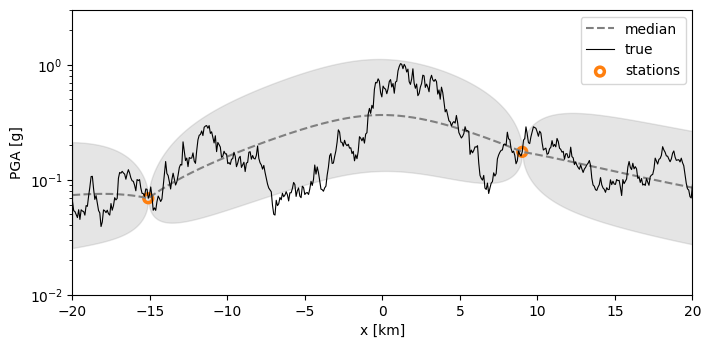

In [10]:
# Compute mean and 5%, 95% quantiles
temp_fac = stats.norm.ppf(0.95) * np.sqrt(np.diag(Sigma_BB_S))
logIMstats = np.append(mu_B_S[None,:],
          np.stack([mu_B_S + i for i in [-temp_fac, +temp_fac]]),
          axis=0)
imB_imS = xr.DataArray(np.exp(logIMstats), dims = ['stat', 'x'],
                    coords = {'stat': ['median', 'q05', 'q95'],
                              'x': survey_sites.coor[:,0]})

fig, ax = plt.subplots(figsize=(8,3.7))
# Prior: Conditional on station data
ax.plot(imB_imS.x, imB_imS.loc['median'], color='gray', zorder=2,
        label='median', ls='--')
ax.fill_between(imB_imS.x, imB_imS.loc['q95'], imB_imS.loc['q05'],
                color='gray', alpha=0.2, zorder=1)
# True: Simulated values
ax.plot(imB_true.x, imB_true.values, color='black', lw=0.8, zorder=5, label='true')
ax.scatter(station_sites.coor[:,0], np.exp(obs_logIM), marker='o', color='none',
           edgecolor = 'tab:orange', lw = 2.5, s = 40, label = 'stations')
ax.set_ylim([0.01, 3]); ax.set_xlim([-20,20])
ax.set_yscale('log'); ax.legend()
ax.set_xlabel('x [km]'); ax.set_ylabel('PGA [g]')
plt.show()

## Fragility function parametrization

A fragility function plots the probability of reaching or exceeding a certain damage state, $ds$, for increasing levels of ground motion intensity, $im$. The most popular functional form for fragility functions is based on the log-normal cumulative distribution. This functional form can be parametrized in different ways as discussed below.

**Conventional parametrization**

$$
    \mathrm{P}(DS \geq ds | im) = \Phi \left( \frac{\ln (im/ \theta_{ds})}{\beta_{ds}} \right)
$$
where $\Phi(\cdot)$ is the standard normal cumulative distribution function, $\theta_{ds}$ denotes the median $\mathit{IM}$ which causes the structure to reach or exceed $ds$, and $\beta_{ds}$ is the standard deviation of the $\ln \mathit{IM}$, here referred to as the dispersion parameter. To avoid a crossing of the fragility functions, we choose an identical dispersion parameter $\beta$ for all damage states. This is a standard assumption taken in analytical and empirical fragility modeling for ordered damage states. For this example with three possible damage states, $ds \in \{0,1,2\}$, we have two increasing parameters $\theta_1 < \theta_2$ and one common dispersion parameter $\beta$.

**Cumulative probit parametrization**

For inference, we use the cumulative probit fragility function parametrization
$$
    \mathrm{P}(DS \geq ds | im) = \Phi \left( \beta^{-1} \ln im - \eta_{ds} \right)
$$
where $\beta$ is the dispersion parameter from above and $\eta_{ds}$ are increasing threshold parameters. To account for this ordering in the estimation algorithms, we introduce positive parameters $\delta_{ds}=\eta_{ds} - \eta_{ds-1}$ for states $ds>1$. In this example, we have three parameters collectively denoted as vector $\boldsymbol{\vartheta}=[\beta, \eta_1, \delta_2]^\top$. While inference is performed on parameters $\boldsymbol{\vartheta}$, the estimated parameters can be transformed to the conventionally used parameters $[\beta, \theta_1, \theta_2]^\top$ with:
\begin{align*}
\eta_{2} &= \eta_{1} + \delta_2 &&  \\
\theta_{ds} &= \exp (\beta \, \eta_{ds}) && \; \forall ds \in \{1,2\} \\
\end{align*}

**Probability mass function**

From the fragility functions, one obtains the probability mass function, $\mathrm{P}(\mathit{DS}=ds | im)=p(ds | im)$, as
\begin{equation*}
    p(\mathit{ds} \vert im) =   
    \begin{cases}
      1-\mathrm{P}(DS \geq ds+1 | im), & \text{if $ds=0$}
    \\
      \mathrm{P}(DS \geq ds | im), & \text{if $ds=c$}
    \\
      \mathrm{P}(DS \geq ds | im) - \mathrm{P}(DS \geq ds+1 | im), & \text{otherwise}~.
    \end{cases}
\end{equation*}
We denote the fragility model in terms of the probability mass function $p(ds|im,\boldsymbol{\vartheta})$, where we explicitly condition on parameters $\boldsymbol{\vartheta}$.

Typically, the surveyed buildings are classified into different building classes, $bc \in \mathcal{BC}$ and estimates separate parameters $\boldsymbol{\vartheta}_{bc}$ for each building class. The total set of parameters are $\boldsymbol{\vartheta}=\{\boldsymbol{\vartheta}_{bc} | bc \in \mathcal{BC}\}$.

For a building of class $bc$ subjected to $\ln im$, the function `get_pmf_ds_logIM` computes the probabilities of being in each damage state conditional on parameters $\boldsymbol{\vartheta}$. Please see the documentation for further information.

In [11]:
from bayesfrag.utils import get_pmf_ds_logIM

## Bayesian inference with uncertain IMs

To account for ground motion uncertainty, we take a Bayesian approach treating both the fragility function parameters, $\boldsymbol{\vartheta}$, and the $\mathit{IM}$ values at the survey sites, $\mathbf{im}_\mathcal{B}$, as realizations of random variables. The joint posterior distribution of $\mathbf{im}_\mathcal{B}$ and $\boldsymbol{\vartheta}$ conditional on the triplet of damage survey data, $\mathbf{ds}$, station data, $\mathbf{im}_\mathcal{S}$, and rupture characteristics, $\mathbf{rup}$, as
$$
p(\boldsymbol{\vartheta}, \mathbf{im}_\mathcal{B} | \mathbf{ds}, \mathbf{im}_\mathcal{S}, \mathbf{rup}) = \left( \prod_{i=1}^n p(ds_i\vert im_i, \boldsymbol{\vartheta}) \right) \frac{ p(\mathbf{im}_\mathcal{B}\vert\mathbf{im}_\mathcal{S},\mathbf{rup}) p(\boldsymbol{\vartheta})}{p(\mathbf{ds}|\mathbf{im}_\mathcal{S},\mathbf{rup})} ~,
$$
where the denominator, $p(\mathbf{ds}|\mathbf{im}_\mathcal{S},\mathbf{rup})$, is the marginal likelihood, i.e., the probability that the prior model assigns to the observed damage data conditional on station data and rupture characteristics, and $p(\boldsymbol{\vartheta})$ is the prior distribution of the fragility function parameters.

The prior distributions are specified below and also illustrated in Appendix B of the supporting manuscript.

In [12]:
from bayesfrag.utils import default_priors

parampriors = default_priors(n_bc = len(args['list_bc']),
                             n_ds = len(args['list_ds']))

The prior generative model is implemented in `numpyro` in four steps explained below.

First, we sample fragility function parameters, $\vartheta \sim p(\vartheta)$.

Second, we use a whitening transformation to generate samples from $p(\mathbf{im}_\mathcal{B}|\mathbf{im}_\mathcal{S}, \mathbf{rup})$. Specifically, we sample a random vector $\mathbf{z}$ that consists of $n$ independent standard normal variables $z_i \sim \mathcal{N}(0,1) \, \forall i \in \{1,\dots,n\}$. The vector $\mathbf{z}$ is transformed to sampled IM values at the building sites $\mathbf{im}_\mathcal{B}=\exp (\boldsymbol{\mu}_{\mathcal{B}|\mathcal{S}} + \mathbf{L} \mathbf{z})$, where $\mathbf{L}$ is the lower Cholesky transform, i.e., $\mathbf{L}\mathbf{L}^\top =\boldsymbol{\Sigma}_{\mathcal{BB}|\mathcal{S}}$.

Third, we compute damage state probabilities conditional on the IM samples and the fragility parameter samples, $p_{ds,i} = p(ds | im_i, \boldsymbol{\vartheta}) \; \forall \,  (ds, i) \in \{0,1, \dots,c\} \times \{1,\dots,n\}$ using `get_pmf_ds_logIM`.

Finally, the damage state is sampled from a categorical distribution $ds_i | im_i,  \boldsymbol{\vartheta} \sim \mathrm{Cat}(p_{0,i}, \dots, p_{c,i}) \; \; \forall \,  i \in \{1,\dots,n\}$.

With this model, we then perform MCMC and obtain posterior samples of $\boldsymbol{\vartheta}$ and of whitening variables $\mathbf{z}$. The object `Bayesian_MCMC` provides a wrapper around the `numpyro` MCMC model and is used for inference. From the MCMC results, we initialize a `Posterior` object. The object has a set of methods that help in the post-processing of the results that will be illustrated below. The inference may take between 3 and 5 minutes.

In [13]:
from bayesfrag.inference import Bayesian_MCMC
bayes_mcmc = Bayesian_MCMC(parampriors, args)

# Compute lower Cholesky decomposition of Sigma_BB_S
L_BB_S = np.linalg.cholesky(Sigma_BB_S)

# Perform MCMC
bayes_mcmc.run_mcmc(mu = mu_B_S, L = L_BB_S,
        ds = obs_DS, bc = obs_BC)

# Collect results in a Posterior object
posterior = bayes_mcmc.get_posterior()

/content/BayesFrag/bayesfrag/inference.py:110: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(NUTS(self.Model), **self.args['mcmc'])
warmup:  25%|██▍       | 433/1750 [00:18<00:56, 23.45it/s, 63 steps of size 7.47e-02. acc. prob=0.78]


KeyboardInterrupt: ignored

### Testing convergence of MCMC chains

To flag potential convergence issues, we use the diagnostic metrics and thresholds proposed by [Vehtari et al. (2019)](https://doi.org/10.1214/20-BA1221) also summarized in Appendix C of the supporting manuscript.

In this example, inference is performed for 503 variables: 3 fragility parameters and 500 whitening variables, $\mathbf{z}$, linked to the IMs at the locations of the 500 surveyed buildings, $\mathbf{im}_\mathcal{B}$. According to the recommendations, no variables are flagged for potential problems. Thus, the chosen MCMC inputs (number of chains, samples per chain, and warum-up steps per chain) are ok.

In [ ]:
dfdiagnostic = posterior.get_diagnostics()

### Estimated fragility functions

The estimated mean parameters (average over posterior parameter samples) can be accessed with `get_mean_fragparams`.

The standard output is in terms of the conventional parametrization that uses $\theta_{ds}$, i.e., the median IM which causes a structure to reach or exceed $ds$. If option is changed to 'etas', the output is in terms of the thresholds $\eta_{ds}=\ln{\theta_{ds}}/\beta$.

In [ ]:
posterior.get_mean_fragparams(option='thetas').round(2)

Load the true fragility parameters used to generate the data

In [17]:
# True data-generating parameters
from bayesfrag.postprocess import PointEstimates
true_params = xr.load_dataset(data_dir + 'True_Frag_OneDim.nc')
true_params = PointEstimates(true_params)
true_params.get_fragparams(option = 'thetas')

,beta,theta1,theta2
bc,,,
A,0.65,0.2,0.65


Plot to compare estimated with true fragility functions

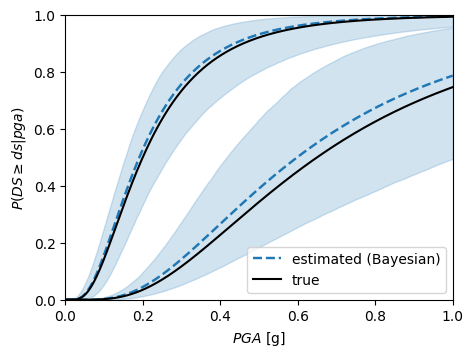

In [18]:
bc = 'A' # Only one building class in this example
im = np.linspace(0.001,1,500) # Horizontal axis

fig, ax = plt.subplots(figsize=(5,3.7))
posterior.plot_frag_funcs(ax, bc=bc, im=im, color = 'tab:blue',
                    kwargsm={'ls': '--', 'lw': 1.75, 'label': 'estimated (Bayesian)'})
true_params.plot_frag_funcs(ax, bc = bc, im = im, color = 'black',
                    kwargs={'ls': '-', 'label': 'true'})
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set_ylabel('$P(DS \geq ds|pga)$')
ax.set_xlabel('$PGA$ [g]')
ax.legend()
plt.show()

### Posterior IM values

We transform the posterior samples of $\mathbf{z}$ to samples of $p(\mathbf{im}_\mathcal{B}|\mathbf{ds}, \mathbf{im}_\mathcal{S}, \mathbf{rup})$.

In [19]:
samples_logIM = posterior.get_logIM_samples(mu_B_S, L_BB_S)

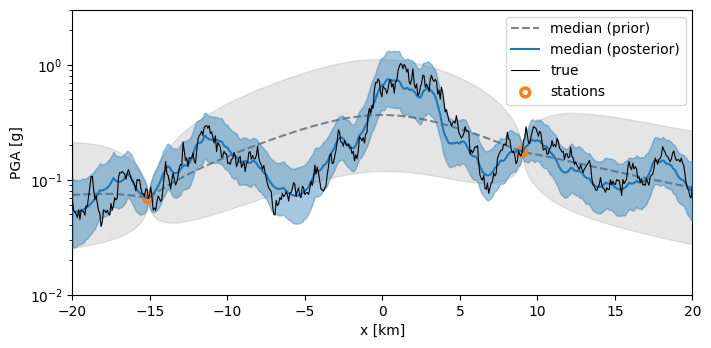

In [20]:
# Compute mean and 5%, 95% quantiles
logIMstats = np.append(np.mean(samples_logIM, axis=1)[None,:],
          np.quantile(samples_logIM, [0.05, 0.95], axis=1),
          axis=0)
imB_ds_imS = xr.DataArray(np.exp(logIMstats), dims = ['stat', 'x'],
                    coords = {'stat': ['median', 'q05', 'q95'],
                              'x': survey_sites.coor[:,0]})

fig, ax = plt.subplots(figsize=(8,3.7))
# Prior: Conditional on station data
ax.plot(imB_imS.x, imB_imS.loc['median'], color='gray', zorder=2,
        label='median (prior)', ls='--')
ax.fill_between(imB_imS.x, imB_imS.loc['q95'], imB_imS.loc['q05'],
                color='gray', alpha=0.2, zorder=1)
# Posterior: Conditional on station data AND damage survey data
ax.plot(imB_ds_imS.x, imB_ds_imS.loc['median'], color='tab:blue',
        zorder=4, label='median (posterior)')
ax.fill_between(imB_ds_imS.x, imB_ds_imS.loc['q95'],
                imB_ds_imS.loc['q05'], color='tab:blue', alpha=0.4, zorder=3)
# True: Simulated values
ax.plot(imB_true.x, imB_true.values, color='black', lw=0.8, zorder=5, label='true')
ax.scatter(station_sites.coor[:,0], np.exp(obs_logIM), marker='o', color='none',
           edgecolor = 'tab:orange', lw = 2.5, s = 40, label = 'stations', zorder=3)
ax.set_ylim([0.01, 3]); ax.set_xlim([-20,20])
ax.set_yscale('log'); ax.legend()
ax.set_xlabel('x [km]'); ax.set_ylabel('PGA [g]')
plt.show()

### Save the results

Below, we store the results to a google drive.

In [37]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

# Modify this according to the path in your drive
res_dir = '/content/drive/MyDrive/EmpFrag_Res/OneDim/'

Mounted at /content/drive/


The main object of interest are the posterior samples of the fragility function parameters. The function `save_as_netcdf` exports the parameters $\boldsymbol{\vartheta}=[\beta, \eta_1,\delta_2]^\top$. To avoid unnecessarily large file sizes, we do not export the posterior samples of $\mathbf{z}$. Instead, we only store the IM statistics illustrated in the above figure.

In [38]:
# Store fragility function results
filepath = (res_dir + 'Bayesian_frag_OneDim_im_' +
            args['im_string'] + '.nc')
posterior.save_as_netcdf(filepath = filepath, include_z = False)

# Store IM statistics for plotting
ds = xr.Dataset({'imB_imS': imB_imS, 'imB_ds_imS' : imB_ds_imS, 'imB_true': imB_true})
ds.attrs = posterior.samples.attrs
ds.to_netcdf(res_dir + 'IMresults_OneDim_' + args['im_string'] + '.nc')

## Maximum likelihood inference with fixed IM values

This estimation method replaces uncertain IM values at the survey sites with fixed, best estimate, values derived from the conditional distribution $p(\mathbf{im}_\mathcal{B}|\mathbf{im}_\mathcal{S}, \mathbf{rup})$. For site $i$, the best-estimate value corresponds to $\widetilde{im}_i = \exp [\boldsymbol{\mu}_{\mathcal{B}|\mathcal{S}}]_i$, which is the median IM conditional on station data $\mathbf{im}_\mathcal{S}$. Then, parameters are estimated via log-likelihood maximization.
$$
    \hat{\boldsymbol{\vartheta}} =
    \underset{\boldsymbol{\vartheta}}{\mathrm{argmax}}\   \sum_{i=1}^n \ln p(ds_i | \widetilde{im}_i, \boldsymbol{\vartheta}) ~.
$$

Note that there exist many different packages to perform such a maximum likelihood inference. The herein presented NumPyro implementation allows to use a similar computational model than the MCMC model presented above. However, here we use scalar values for the fragility parameters (instead of sampling from prior distributions as with MCMC). The assigned initial values correspond to the mean values from the employed prior distributions. The `MLE_fixedIM` object is a wrapper that performs maximum likelihood inference. From the estimated parameters, we initialize a `PointEstimates` object that helps in post-processing and visualization of the results.

In [21]:
from bayesfrag.inference import MLE_fixedIM

# Specify initial values for parameters
init_values = dict()
for param in parampriors.keys():
  init_values[param] = parampriors[param].mean

mle_fixedIM = MLE_fixedIM(init_values, args)
res_fixedIM = mle_fixedIM.run(logIM = mu_B_S, ds = obs_DS, bc = obs_BC)

100%|██████████| 1000/1000 [00:04<00:00, 229.18it/s, init loss: 365.8756, avg. loss [951-1000]: 365.8756]


### Estimated fragility functions

The estimated parameters in terms of the conventional parametrization that uses $\theta_{ds}$.

In [22]:
res_fixedIM.get_fragparams(option = 'thetas').round(2)

,beta,theta1,theta2
bc,,,
A,0.92,0.25,0.8


Compare to true parameters used to simulate the data

In [23]:
true_params.get_fragparams(option = 'thetas')

,beta,theta1,theta2
bc,,,
A,0.65,0.2,0.65


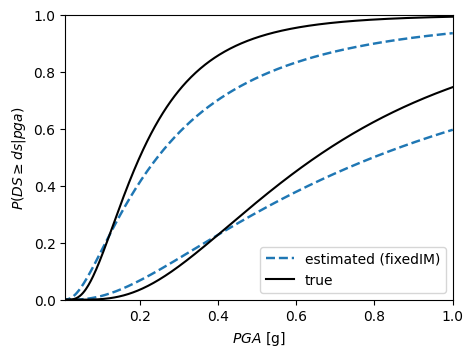

In [24]:
bc = 'A'
im = np.linspace(0.001,1,500)
fig, ax = plt.subplots(figsize=(5,3.7))
res_fixedIM.plot_frag_funcs(ax, bc = bc, im = im, color = 'tab:blue',
                    kwargs={'ls': '--', 'lw': 1.75, 'label': 'estimated (fixedIM)'})
true_params.plot_frag_funcs(ax, bc = bc, im = im, color = 'black',
                    kwargs={'ls': '-', 'label': 'true'})
ax.set_ylim([0,1])
ax.set_xlim([0.01,1])
ax.set_ylabel('$P(DS \geq ds|pga)$')
ax.set_xlabel('$PGA$ [g]')
ax.legend()
plt.show()

### Save the estimated parameters

In [61]:
# Store fragility function results
filepath = (res_dir + 'FixedIM_frag_OneDim_im_' +
            args['im_string'] + '.nc')
res_fixedIM.save_as_netcdf(filepath = filepath)